In [4]:
from comet_ml import Experiment
import numpy as np
import os
import sys


DATA_PATH = '../../IFT6758_Data/'
PROJECT_PATH = '../../Milestone2/'


sys.path.append(PROJECT_PATH)
from features.tidy_data import tidy_data
from visualizations.simple_visualization import *

In [ ]:
with open('../../COMET_API_KEY.txt', 'r') as f:
    my_key = f.read()

experiment = Experiment(
  api_key=my_key,
  project_name="nhl-project-b10",
  workspace="ift6758b-project-b10"
)

### We split the data into training, validation and test sets:

#### Train set : 2016/2017-2018/2019
#### Validation set : 2019/2020
#### Test set : 2020/2021

In [6]:
train_df = year_integration(DATA_PATH, 2016)
train_df = pd.concat([train_df, year_integration(DATA_PATH, 2017)], ignore_index=True)
train_df = pd.concat([train_df, year_integration(DATA_PATH, 2018)], ignore_index=True)
train_df

,game_id,homeTeam,awayTeam,periodType,period,periodTime,team,eventType,x_coordinate,y_coordinate,goal_location,shooter,goalie,shotType,emptyNet,strength
0,2016020001,OTT,TOR,REGULAR,1,01:11,TOR,Shot,-77.0,5.0,Right,Mitchell Marner,Craig Anderson,Wrist Shot,None,None
1,2016020001,OTT,TOR,REGULAR,1,02:53,OTT,Shot,86.0,13.0,Left,Chris Kelly,Frederik Andersen,Wrist Shot,None,None
2,2016020001,OTT,TOR,REGULAR,1,04:01,OTT,Shot,23.0,-38.0,Left,Cody Ceci,Frederik Andersen,Wrist Shot,None,None
3,2016020001,OTT,TOR,REGULAR,1,04:46,OTT,Shot,33.0,-15.0,Left,Erik Karlsson,Frederik Andersen,Slap Shot,None,None
4,2016020001,OTT,TOR,REGULAR,1,06:46,TOR,Shot,-34.0,28.0,Right,Martin Marincin,Craig Anderson,Wrist Shot,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253470,2018030417,BOS,STL,REGULAR,3,15:22,STL,Goal,-77.0,7.0,Right,Zach Sanford,Tuukka Rask,Snap Shot,False,EVEN
253471,2018030417,BOS,STL,REGULAR,3,15:51,STL,Shot,-69.0,7.0,Right,Alexander Steen,Tuukka Rask,Snap Shot,None,None
253472,2018030417,BOS,STL,REGULAR,3,15:55,STL,Shot,-65.0,-4.0,Right,Ryan O'Reilly,Tuukka Rask,Snap Shot,None,None
253473,2018030417,BOS,STL,REGULAR,3,16:50,BOS,Shot,42.0,3.0,Left,Marcus Johansson,Jordan Binnington,Wrist Shot,None,None


## Question 1

In [28]:
def calculate_shot_angle(df):
    if df['goal_location'] == 'Left':
        # calculate angle to (-89, 0)
        return np.degrees(np.arctan2(np.abs(df['y_coordinate']), np.abs(df['x_coordinate'] + 89)))
    elif df['goal_location'] == 'Right':
        # calculate angle to (89, 0)
        return np.degrees(np.arctan2(np.abs(df['y_coordinate']), np.abs(df['x_coordinate'] - 89)))
    
df = train_df.copy()
df['shot_angle'] = df.apply(calculate_shot_angle, axis=1)
df['shot_distance'] = df.apply(calculate_shot_distance, axis=1)

In [29]:
def standardize_emptyNet(df):
    if df['emptyNet'] == True:
        return 1
    else:
        return 0
    
df['emptyNet'] = df.apply(standardize_emptyNet, axis=1)

In [30]:
def is_goal(df):
    if df['eventType'] == 'Goal':
        return 1
    else:
        return 0
    
df['is_goal'] = df.apply(is_goal, axis=1)
df

,game_id,homeTeam,awayTeam,periodType,period,periodTime,team,eventType,x_coordinate,y_coordinate,goal_location,shooter,goalie,shotType,emptyNet,strength,shot_angle,shot_distance,is_goal
0,2016020001,OTT,TOR,REGULAR,1,01:11,TOR,Shot,-77.0,5.0,Right,Mitchell Marner,Craig Anderson,Wrist Shot,0,None,1.725255,166.075284,0
1,2016020001,OTT,TOR,REGULAR,1,02:53,OTT,Shot,86.0,13.0,Left,Chris Kelly,Frederik Andersen,Wrist Shot,0,None,4.248455,175.482193,0
2,2016020001,OTT,TOR,REGULAR,1,04:01,OTT,Shot,23.0,-38.0,Left,Cody Ceci,Frederik Andersen,Wrist Shot,0,None,18.741340,118.270876,0
3,2016020001,OTT,TOR,REGULAR,1,04:46,OTT,Shot,33.0,-15.0,Left,Erik Karlsson,Frederik Andersen,Slap Shot,0,None,7.009384,122.918672,0
4,2016020001,OTT,TOR,REGULAR,1,06:46,TOR,Shot,-34.0,28.0,Right,Martin Marincin,Craig Anderson,Wrist Shot,0,None,12.824398,126.146740,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253470,2018030417,BOS,STL,REGULAR,3,15:22,STL,Goal,-77.0,7.0,Right,Zach Sanford,Tuukka Rask,Snap Shot,0,EVEN,2.414657,166.147525,1
253471,2018030417,BOS,STL,REGULAR,3,15:51,STL,Shot,-69.0,7.0,Right,Alexander Steen,Tuukka Rask,Snap Shot,0,None,2.536762,158.154987,0
253472,2018030417,BOS,STL,REGULAR,3,15:55,STL,Shot,-65.0,-4.0,Right,Ryan O'Reilly,Tuukka Rask,Snap Shot,0,None,1.487868,154.051939,0
253473,2018030417,BOS,STL,REGULAR,3,16:50,BOS,Shot,42.0,3.0,Left,Marcus Johansson,Jordan Binnington,Wrist Shot,0,None,1.311888,131.034347,0


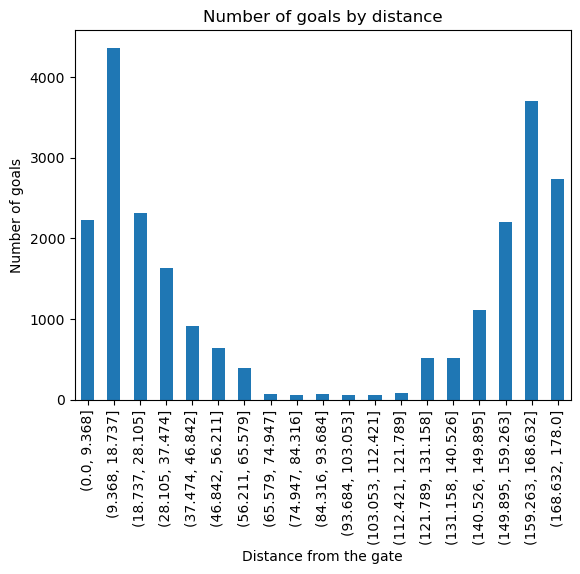

In [53]:
def bin_by_distance(df):

    max_distance = np.sqrt((89*2)**2 + 0**2)
    min_distance = 0

    # divide the distance into 20 bins
    bins = np.linspace(min_distance, max_distance, 20)

    df['distance_bin'] = pd.cut(df['shot_distance'], bins=bins)
    df = df[df['is_goal'] == 1]
    df_goal_count = df.groupby(['distance_bin']).count()['is_goal']

    df_goal_count.plot(kind='bar', x='distance_bin', y='is_goal')
    plt.xlabel('Distance from the gate')
    plt.ylabel('Number of goals')
    plt.title('Number of goals by distance')
    plt.show()

bin_by_distance(df)


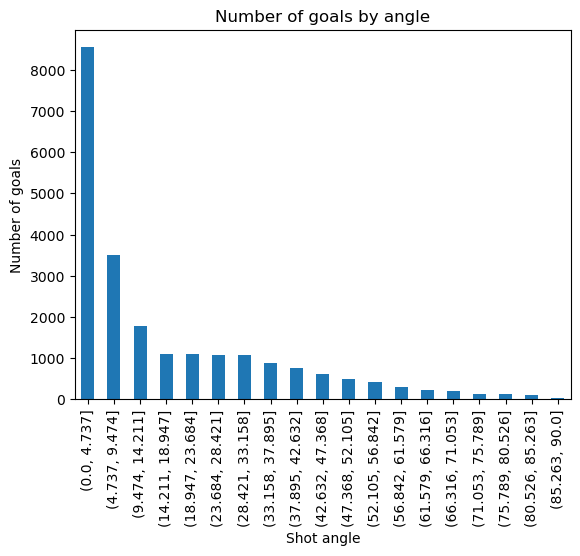

In [52]:
def bin_by_angle(df):
    
        max_angle = 90
        min_angle = 0
    
        # divide the distance into 20 bins
        bins = np.linspace(min_angle, max_angle, 20)
    
        df['angle_bin'] = pd.cut(df['shot_angle'], bins=bins)
        df = df[df['is_goal'] == 1]
        df_goal_count = df.groupby(['angle_bin']).count()['is_goal']
    
        df_goal_count.plot(kind='bar', x='angle_bin', y='is_goal')
        plt.xlabel('Shot angle')
        plt.ylabel('Number of goals')
        plt.title('Number of goals by angle')
        plt.show()

bin_by_angle(df)

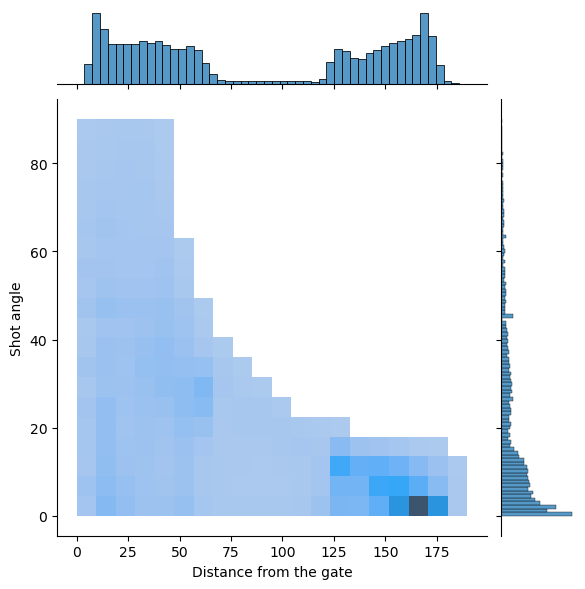

In [48]:
def joint_plot(df):
    sns.jointplot(x='shot_distance', y='shot_angle', data=df, kind='hist', bins=20)
    plt.xlabel('Distance from the gate')
    plt.ylabel('Shot angle')
    plt.show()

joint_plot(df)

## Question 2

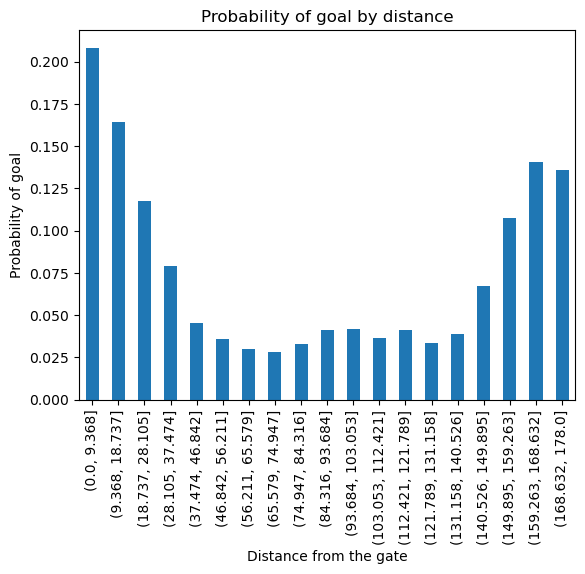

In [51]:
def prob_by_distance(df):
    df_goal = df[df['is_goal'] == 1]
    df_goal_count = df_goal.groupby(['distance_bin']).count()['is_goal']
    df_total_count = df.groupby(['distance_bin']).count()['is_goal']
    df_goal_prob = df_goal_count / df_total_count

    df_goal_prob.plot(kind='bar', x='distance_bin', y='is_goal')
    plt.xlabel('Distance from the gate')
    plt.ylabel('Probability of goal')
    plt.title('Probability of goal by distance')
    plt.show()

prob_by_distance(df)



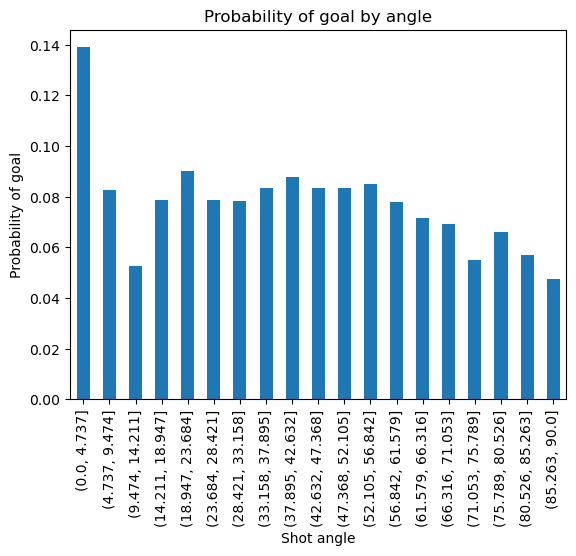

In [54]:
def prob_by_angle(df):
    df_goal = df[df['is_goal'] == 1]
    df_goal_count = df_goal.groupby(['angle_bin']).count()['is_goal']
    df_total_count = df.groupby(['angle_bin']).count()['is_goal']
    df_goal_prob = df_goal_count / df_total_count

    df_goal_prob.plot(kind='bar', x='angle_bin', y='is_goal')
    plt.xlabel('Shot angle')
    plt.ylabel('Probability of goal')
    plt.title('Probability of goal by angle')
    plt.show()

prob_by_angle(df)